In [1]:
import ROOT as rt
# import root_numpy as rtnp
import csv
import re
import sys
import collections

from collections import OrderedDict
import uproot
import awkward
import numpy as np
import time
import numba
from numba import jit
from matplotlib import pyplot as plt
sys.path.append('/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/lib/')
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 0

wH = 1
Z_MASS = 91.2


# donotdelete = []
print(sys.version)

Welcome to JupyROOT 6.18/02
3.6.8 (default, Aug  7 2019, 17:28:10) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-39)]


# Load ntuples

In [2]:
fpath =OrderedDict()
tree = OrderedDict()
weight = {}
weight_sum = {}


start_t = time.time()
data_year = 'full'
pdgId = 13
analyzer_version = "/v3/vBDT13/"
data_version = '/v1/vBDT13/'
ntupler_version ='V1p15'
ctau = [100, 1000, 10000, 100000]
years = ['Summer16', 'Fall17', 'Fall18']
mass = [15, 40, 55]



# data_path = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p12/Data'+str(data_year)+'/vBDT/v2/normalized/'
# mc_path = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p12/MC_RunIIFall18/vBDT/v2/normalized/'


data_path = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p15/Data2018/'+data_version+'/normalized/'
fpath['data'] = data_path + 'Run2_displacedJetMuonNtupler_'+ntupler_version+'_Data2016_Data2017_Data2018-HighMET_goodLumi.root'

for y in years:
    mc_path = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/'+ntupler_version+'/MC_'+y+'/'+analyzer_version+'/normalized/'
    tune = 'TuneCP5'
    if y == 'Summer16': tune = 'TuneCUETP8M1'
    for m in mass:
        for ct in ctau:
            key = 'MC_'+y+'_ggH_'+str(m)+'_'+str(ct)                       
            fpath[key] = mc_path+'ggH_HToSSTobbbb_MH-125_MS-'+str(m)+'_ctau-'+str(ct)+'_' + tune + '_13TeV-powheg-pythia8_1pb_weighted.root'



NEvents = {}
total_signal = 0
NEvents_genweight = {}
for k,v in fpath.items():
#     print (k, v)
#     tree[k] = rtnp.root2array(v)
    root_dir = uproot.open(v) 
    if not root_dir: 
        print(k, "zombie")
        continue
    tree[k] = root_dir['MuonSystem']
    NEvents[k] = root_dir['NEvents'][1]
    weight[k] = tree[k]["weight"].array()
    weight_sum[k] = np.sum(weight[k])
    print("NEvents",k,NEvents[k], weight_sum[k], len(weight[k]))
    if not k == 'data': total_signal += NEvents[k]
    
print(total_signal)
print(time.time()-start_t)

NEvents data 22762296.0 4561.0 4561
NEvents MC_Summer16_ggH_15_100 1744932.2 0.08559988 3075
NEvents MC_Summer16_ggH_15_1000 1697936.6 3.021331 105604
NEvents MC_Summer16_ggH_15_10000 1767933.5 1.0788144 39262
NEvents MC_Summer16_ggH_15_100000 1744934.4 0.12870398 4623
NEvents MC_Summer16_ggH_40_100 1794318.8 0.0012995685 48
NEvents MC_Summer16_ggH_40_1000 1758938.2 1.2660794 45843
NEvents MC_Summer16_ggH_40_10000 1699938.4 2.587063 90531
NEvents MC_Summer16_ggH_40_100000 1851418.0 0.43225336 16474
NEvents MC_Summer16_ggH_55_100 1658939.9 0.00032212134 11
NEvents MC_Summer16_ggH_55_1000 1762938.1 0.38361686 13922
NEvents MC_Summer16_ggH_55_10000 1716167.4 2.853773 100818
NEvents MC_Summer16_ggH_55_100000 1767935.6 0.69194126 25182
NEvents MC_Fall17_ggH_15_100 25791628.0 0.0731825 1803
NEvents MC_Fall17_ggH_15_1000 24522924.0 2.908901 68270
NEvents MC_Fall17_ggH_15_10000 25273904.0 1.040681 25154
NEvents MC_Fall17_ggH_15_100000 24309876.0 0.12672487 2945
NEvents MC_Fall17_ggH_40_100 256

# Helper Functions

In [4]:


# Imports
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score
import numpy as np
import pandas as pd
import math
import pickle as pickle
import ROOT as root
import os
import shlex
import uproot
import seaborn as sns

# variables = [
#             ['cscRechitClusterNStation', 'cscRechitClusterNStation', '$N_{station}$', 5, 0, 5],
#             ['cscRechitClusterXSpread', 'cscRechitClusterXSpread', 'X spread [cm]', 50, 0, 150],
#             ['cscRechitClusterYSpread', 'cscRechitClusterYSpread', 'Y spread [cm]', 50, 0, 150],
#             ['cscRechitClusterXYSpread', 'cscRechitClusterXYSpread', 'XY spread [cm]', 50, 0, 150],
#             ['cscRechitClusterPhi', 'cscRechitClusterPhi', 'cluster $\phi$',25, 0, 3.2],
#             ['cscRechitClusterEta', 'cscRechitClusterEta', 'cluster $\eta$',  25, 0.5, 2.5],
#             ['cscRechitClusterZ', 'cscRechitClusterZ', 'cluster Z [cm]', 30, 600, 1100],
#             ]

# variables_mc = [
#             ['cscRechitClusterNStation', 'cscRechitClusterNStation', '$N_{station}$', 5, 0, 5],
#             ['cscRechitClusterXSpread_phi0p7_r1p2', 'cscRechitClusterXSpread', 'X spread [cm]', 50, 0, 150],
#             ['cscRechitClusterYSpread_phi0p7_r1p2', 'cscRechitClusterYSpread', 'Y spread [cm]', 50, 0, 150],
#             ['cscRechitClusterXYSpread_phi0p7_r1p2', 'cscRechitClusterXYSpread', 'XY spread [cm]', 50, 0, 150],
#             ['cscRechitClusterPhi', 'cscRechitClusterPhi', 'cluster $\phi$',25, 0, 3.2],
#             ['cscRechitClusterEta', 'cscRechitClusterEta', 'cluster $\eta$',  25, 0.5, 2.5],
#             ['cscRechitClusterZ', 'cscRechitClusterZ', 'cluster Z [cm]', 30, 600, 1100],
#             ]


variables = [
            ['cscRechitClusterNStation', 'cscRechitClusterNStation', '$N_{station}$', 5, 0, 5],
            ['cscRechitClusterXSpread', 'cscRechitClusterXSpread', 'X spread [cm]', 50, 0, 150],
            ['cscRechitClusterYSpread', 'cscRechitClusterYSpread', 'Y spread [cm]', 50, 0, 150],
            ['cscRechitClusterXYSpread', 'cscRechitClusterXYSpread', 'XY spread [cm]', 50, 0, 150],
            ['cscRechitClusterPhi', 'cscRechitClusterPhi', 'cluster $\phi$',25, 0, 3.2],
            ['cscRechitClusterEta', 'cscRechitClusterEta', 'cluster $\eta$',  25, 0.5, 2.5],
            ['cscRechitClusterAvgStation5', 'cscRechitClusterAvgStation5', 'cluster station', 30, 1, 4],

            ]
variables_mc = [
            ['cscRechitClusterNStation5', 'cscRechitClusterNStation', '$N_{station}$', 5, 0, 5],
            ['cscRechitClusterXSpread_corr', 'cscRechitClusterXSpread', 'X spread [cm]', 50, 0, 150],
            ['cscRechitClusterYSpread_corr', 'cscRechitClusterYSpread', 'Y spread [cm]', 50, 0, 150],
            ['cscRechitClusterXYSpread_corr', 'cscRechitClusterXYSpread', 'XY spread [cm]', 50, 0, 150],
            ['cscRechitClusterPhi', 'cscRechitClusterPhi', 'cluster $\phi$',25, 0, 3.2],
            ['cscRechitClusterEta', 'cscRechitClusterEta', 'cluster $\eta$',  25, 0.5, 2.5],
            ['cscRechitClusterAvgStation5', 'cscRechitClusterAvgStation5', 'cluster station', 30, 1, 4],
            ]

# correlation with n_rechits

In [6]:
# Plotting ncsc
import scipy
start_t = time.time()
c = rt.TCanvas('c','c', 1000, 800)
h = {}
# leg = rt.TLegend(0.50,0.75,0.97,0.93)
leg = rt.TLegend(0.58,0.70,0.94,0.85)
leg.SetTextSize(0.022)
# leg.SetTextFont(42)
leg.SetEntrySeparation(0.01)
T = tree['data']
for i, var in enumerate(variables):
#     evt_selection  = T.array('met') > 200
    nCscRechitClusters = T.array('nCscRechitClusters')
    cscRechits = T.array('cscRechitClusterSize')[nCscRechitClusters>0][:,0]
    variable_check = np.abs(T.array(var[0])[nCscRechitClusters>0][:,0])
    print(var[0],scipy.stats.pearsonr(cscRechits, variable_check))

cscRechitClusterNStation (0.002329892728989767, 0.8750030614344682)
cscRechitClusterXSpread (0.23983193229387356, 1.1093143824728789e-60)
cscRechitClusterYSpread (0.19379156908660225, 7.726336572904193e-40)
cscRechitClusterXYSpread (0.147451237778956, 1.375078493234217e-23)
cscRechitClusterPhi (0.004825057783341603, 0.7445955745900031)
cscRechitClusterEta (-0.023644730303444127, 0.11034675110098707)
cscRechitClusterAvgStation5 (-0.024739981653812512, 0.09479740555639939)


In [5]:
variables_veto = [
            ['cscRechitClusterMuonVetoPt', 'cscRechitClusterMuonVetoPt', '$N_{station}$', 5, 0, 5],
            ['cscRechitClusterMuonVetoE', 'cscRechitClusterMuonVetoE', '$\eta$ spread', 50, 0, 0.3],
            ['cscRechitClusterJetVetoPt', 'cscRechitClusterJetVetoPt', '$\phi$ spread', 50, 0, 0.3],
            ['cscRechitClusterJetVetoE', 'cscRechitClusterJetVetoE', '$\eta-\phi$ spread', 50, 0, 0.2],
      
            ]



## load root files to dataframes & weight

In [6]:
lumi_year = {
    'Summer16': 35.92,
    'Fall17':41.53,
    'Fall18':59.74,
}

# timespread_cut = 2.0


weight_signal = []
df_signal_list  = []
nRechit_list = []
veto_list = []
# timespread_list = []

for y in years:
    print(y)
    for m in mass:
        for ct in ctau:
            key = 'MC_'+y+'_ggH_'+str(m)+'_'+str(ct)                       
            df_signal_temp = uproot.open(fpath[key])['MuonSystem'].pandas.df([row[0] for row in variables_mc], flatten=True)
            df_signal_list.append(df_signal_temp)
            nRechit_list.append(uproot.open(fpath[key])['MuonSystem'].pandas.df(['cscRechitClusterSize'], flatten=True))
#             veto_list.append(uproot.open(fpath[key])['MuonSystem'].pandas.df([row[0] for row in variables_veto], flatten=True))
#             timespread_list.append(uproot.open(fpath[key])['MuonSystem'].pandas.df(['cscRechitClusterEta'], flatten=True))

#             weight_signal = weight_signal + [lumi_year[y]/len(df_signal_temp)]*len(df_signal_temp) #v4
            weight_signal = weight_signal + [lumi_year[y]]*len(df_signal_temp) #v5
            break
df_signal = pd.concat(df_signal_list)
df_bkg = uproot.open(fpath['data'])['MuonSystem'].pandas.df([row[0] for row in variables], flatten=True)
weight_bkg = np.ones((len(df_bkg,)))
weight_signal = np.array(weight_signal)
# df_signal_ts = pd.concat(timespread_list)
# df_bkg_ts = uproot.open(fpath['data'])['MuonSystem'].pandas.df(['cscRechitClusterEta'], flatten=True)

df_signal_ncsc = pd.concat(nRechit_list)
df_bkg_ncsc = uproot.open(fpath['data'])['MuonSystem'].pandas.df(['cscRechitClusterSize'], flatten=True)
nRechits = np.abs(np.concatenate([df_bkg_ncsc,df_signal_ncsc]))


print("values in signal missing: ", df_signal.isnull().values.any())
print("values in bkg missing: ", df_bkg.isnull().values.any())

# weight_signal = weight_signal[np.abs(df_signal_ts.values[:,0])<=timespread_cut]
# df_signal = df_signal.values[np.abs(df_signal_ts.values[:,0])<=timespread_cut]
# df_bkg = df_bkg.values[np.abs(df_bkg_ts.values[:,0])<=timespread_cut]
# weight_bkg = weight_bkg[np.abs(df_bkg_ts.values[:,0])<=timespread_cut]
# df_signal_ncsc = df_signal_ncsc.values[np.abs(df_signal_ts.values[:,0])<=timespread_cut]
# df_bkg_ncsc = df_bkg_ncsc.values[np.abs(df_bkg_ts.values[:,0])<=timespread_cut]

x = np.abs(np.concatenate([df_bkg,df_signal]))
y = np.concatenate([np.zeros(len(df_bkg)),np.ones(len(df_signal))])
weight_signal = weight_signal/np.sum(weight_signal) * np.sum(weight_bkg)


weight = np.hstack((weight_bkg, weight_signal))

assert(len(x) == len(y) == len(weight))

print("Number of signal events: "+ str(len(df_signal)))
print("Number of background events: "+str(len(df_bkg)))
print("Sum of weight for signal events: "+ str(np.sum(weight_signal)))
print("Sum of weight for background events: "+str(len(df_bkg)))

indices = np.arange(len(y))

# df_nRechit_sig = pd.concat(nRechit_list)
# df_nRechit_bkg = uproot.open(fpath['data'])['MuonSystem'].pandas.df('cscRechitClusterSize', flatten=True)
# df_veto_sig = pd.concat(veto_list)

Summer16
Fall17
Fall18
values in signal missing:  False
values in bkg missing:  False
Number of signal events: 8302
Number of background events: 4567
Sum of weight for signal events: 4566.999999999998
Sum of weight for background events: 4567


# muon veto efficiency

In [ ]:
df_muonVetoPt_sig
eff_muonpt = []
eff_muone = []
eff_jetpt = []
eff_jete = []
muonpt = np.array(df_veto_sig['cscRechitClusterMuonVetoPt'])
muone = np.array(df_veto_sig['cscRechitClusterMuonVetoE'])
jetpt = np.array(df_veto_sig['cscRechitClusterJetVetoPt'])
jete = np.array(df_veto_sig['cscRechitClusterJetVetoE'])
cuts = np.arange(0,50,1)
for cut in cuts:
    eff_muonpt.append(np.count_nonzero(muonpt<cut)/len(muonpt))
    eff_muone.append(np.count_nonzero(muone<cut)/len(muone))
    eff_jetpt.append(np.count_nonzero(jetpt<cut)/len(jetpt))
    eff_jete.append(np.count_nonzero(jete<cut)/len(jete))
eff_muonpt = np.array(eff_muonpt)
eff_muone = np.array(eff_muone)
eff_jetpt = np.array(eff_jetpt)
eff_jete = np.array(eff_jete)
print(cuts[np.argmin(abs(eff_muonpt-0.9))])
print(cuts[np.argmin(abs(eff_muone-0.9))])
print(cuts[np.argmin(abs(eff_jetpt-0.9))])
print(cuts[np.argmin(abs(eff_jete-0.9))])
# print(eff_pt)
# print(e[np.argmin(abs(eff_e-0.9))])

### plot input variables

0 0 0
['cscRechitClusterNStation', 'cscRechitClusterNStation', '$N_{station}$', 5, 0, 5]
1 0 1
['cscRechitClusterXSpread', 'cscRechitClusterXSpread', 'X spread [cm]', 50, 0, 150]
2 1 0
['cscRechitClusterYSpread', 'cscRechitClusterYSpread', 'Y spread [cm]', 50, 0, 150]
3 1 1
['cscRechitClusterXYSpread', 'cscRechitClusterXYSpread', 'XY spread [cm]', 50, 0, 150]
4 2 0
['cscRechitClusterPhi', 'cscRechitClusterPhi', 'cluster $\\phi$', 25, 0, 3.2]
5 2 1
['cscRechitClusterEta', 'cscRechitClusterEta', 'cluster $\\eta$', 25, 0.5, 2.5]
6 3 0
['cscRechitClusterAvgStation5', 'cscRechitClusterAvgStation5', 'cluster station', 30, 1, 4]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:36: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


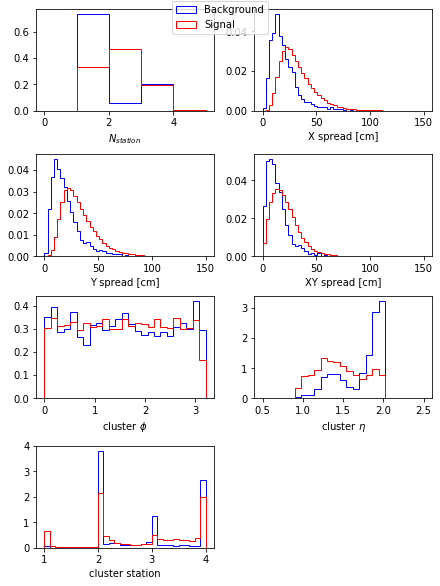

In [12]:

def trim_axs(axs, N):
    """little helper to massage the axs list to have correct length..."""
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]
columns = 2
# fig1, axs = plt.subplots(int(len(variables)/columns)+1, columns, figsize=(8,5), constrained_layout=True)
fig1, axs = plt.subplots(int(len(variables)/columns)+1, columns, figsize=(6,8), constrained_layout=True)


# for ax, case in zip(axs, cases):
#     ax.set_title('markevery=%s' % str(case))
trim_axs(axs, len(variables))

r = 0
c = 0
for i, var in enumerate(variables):
#     axs[i].hist(x[:,i][y==0])
    print(i,r,c)
    print(variables[i])
    bkg = axs[r,c].hist(x[:,i][y==0], variables[i][3], (variables[i][4], variables[i][5]), density = True, histtype = 'step', label = 'Background', color = 'b')
    sig = axs[r,c].hist(x[:,i][y==1], variables[i][3], (variables[i][4], variables[i][5]), density = True, histtype = 'step', label = 'Signal', color = 'r')
#     axs[r,c].legend()
    axs[r,c].set_xlabel(variables[i][2])
    if c == columns-1:
#         if r == 0:axs[r,c].legend(loc = 'upper right')
        c = 0
        r+=1
        
    else:c+=1
#     if i == len(variables)-1:
fig1.legend([bkg, sig],     # The line objects
           labels=['Background', 'Signal'],   # The labels for each line
           loc="upper center",   # Position of legend
           borderaxespad=0.1,    # Small spacing around legend box
           )
#     h['OOT_data'] = create_TH1D(x[:,i][y==0], axis_title = [variables[i][2],'Events'], binning=[variables[i][3], variables[i][4], variables[i][5]])
#     h['MC_signal'] = create_TH1D(x[:,i][y==1], axis_title = [variables[i][2],'Events'], binning=[variables[i][3], variables[i][4], variables[i][5]])

fig1.savefig("../../plots/MuonSystem_Analysis/"+bdt_name+'/input.png', dpi=300)



# train

In [7]:
# split data into train and test sets
seed = 7
test_size = 0.2
sample_size = 1.0
# x_train, x_test, y_train, y_test, indices_train, indices_test = train_test_split(x, y,indices,train_size = sample_size*(1-test_size), test_size=sample_size*test_size, random_state=seed)
x_train, x_test, y_train, y_test, indices_train, indices_test, weight_train, weight_test\
    = train_test_split(x, y,indices, weight, train_size = sample_size*(1-test_size), test_size=sample_size*test_size, random_state=seed)

In [8]:
# fit model no training data
model = xgb.XGBClassifier(max_depth=4, learning_rate=0.1, n_estimators=400, verbosity=1, n_jobs=4, reg_lambda=1.0)
model.fit(x_train, y_train, sample_weight=weight_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=400, n_jobs=4,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1.0, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [9]:
# make predictions for test data
y_pred = model.predict_proba(x_test)[:, 1]
y_pred_train = model.predict_proba(x_train)[:, 1]


predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
bdt_name = 'bdt_flatten_metfilter_me1112nohits_eta2p1_testsize0p2_abs_XYspread_v12'
# import pickle
# pickle.dump(model, open(bdt_name+".pickle", "wb"))


Accuracy: 87.10%


# load bdt

In [6]:
# make predictions for test data

import pickle
# model = pickle.load(open( 'bdt_flatten_noEvtSelection.pickle.dat', "rb" ))
bdt_name = 'bdt_flatten_metfilter_me1112nohits_eta2p1_testsize0p2_abs_XYspread_v11'


model = pickle.load(open( bdt_name+'.pickle', "rb" ))
# y_pred = model.predict_proba([1,2,3,4,4,5,6])[:, 1]
y_pred = model.predict_proba(x_test)[:, 1]
y_pred_train = model.predict_proba(x_train)[:, 1]

predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))


accuracy = accuracy_score(y_train, [round(value) for value in y_pred_train])


print("Accuracy: %.2f%%" % (accuracy * 100.0))


Accuracy: 93.21%
Accuracy: 93.26%


# ROC curve

In [10]:

AUC = roc_auc_score(y_test, y_pred)
print("AUC: "+str(AUC))
#get roc curve
#roc = roc_curve(y_test, y_pred)
fpr, tpr, thr = roc_curve(y_test, y_pred)
# fpr, tpr, thr = roc_curve(y_train, y_pred_train)

AUC: 0.9408677840348021


## significance

In [11]:

significance = []
effSignal = []
effBkg = []
thresholds = []

ctr = 0
for i in range(len(fpr)):
    if fpr[i] > 1e-5 and tpr[i] > 1e-5:
#         print("thr = "+str(thr[i])+", fpr = "+str(fpr[i]) + ", tpr = "+str(tpr[i]))
        #print fpr[i], tpr[i] 
        #significance.append(math.sqrt(lumi)*4.8742592356*0.006431528796*tpr[i]/math.sqrt(fpr[i]*0.9935684712))
#         significance.append(*tpr[i]/math.sqrt(fpr[i]*bkgEvents))
        effSignal.append(tpr[i])
        effBkg.append(fpr[i])
        thresholds.append(thr[i])
        #print significance[ctr], ' ' , fpr[ctr], ' ', tpr[ctr]
        ctr = ctr + 1


# max_significance = max(significance)
# idx_max_significance = np.argmax(np.array(significance))
# best_threshold = thresholds[idx_max_significance]
# best_effSignal = effSignal[idx_max_significance]
# best_effBkg = effBkg[idx_max_significance]

# print("max_significance: "+str(max_significance))
# print("best_threshold: "+str(best_threshold))
# print("best_effSignal: "+str(best_effSignal))
# print("best_effBkg: "+str(best_effBkg))

idx_WP99 = 0
minD0p9 = 999.0
for idx in range(len(effSignal)):
    if abs(effSignal[idx] - 0.99) < minD0p9:
        idx_WP99 = idx
        minD0p9 = abs(effSignal[idx] - 0.99)

# WP90_significance = significance[idx_WP90]
WP99_threshold = thresholds[idx_WP99]
WP99_effSignal = effSignal[idx_WP99]
WP99_effBkg = effBkg[idx_WP99]

# print("WP90_significance: "+str(WP90_significance))
print("WP99_threshold: "+str(WP99_threshold))
print("WP99_effSignal: "+str(WP99_effSignal))
print("WP99_effBkg: "+str(WP99_effBkg))

idx_WP90 = 0
minD0p8 = 999.0
for idx in range(len(effSignal)):
        if abs(effSignal[idx] - 0.90) < minD0p8:
                idx_WP90 = idx
                minD0p8 = abs(effSignal[idx] - 0.90)

# WP80_significance = significance[idx_WP80]
WP90_threshold = thresholds[idx_WP90]
WP90_effSignal = effSignal[idx_WP90]
WP90_effBkg = effBkg[idx_WP90]

# print("WP80_significance: "+str(WP80_significance))
print("WP90_threshold: "+str(WP90_threshold))
print("WP90_effSignal: "+str(WP90_effSignal))
print("WP90_effBkg: "+str(WP90_effBkg))


WP99_threshold: 0.07176307
WP99_effSignal: 0.9899049881235155
WP99_effBkg: 0.596629213483146
WP90_threshold: 0.40533176
WP90_effSignal: 0.9002375296912114
WP90_effBkg: 0.16067415730337078


# plot roc curve

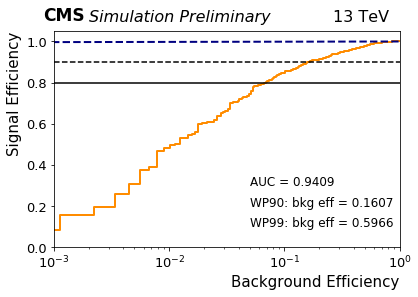

In [12]:

#plot roc curve
f = plt.figure()
ax = f.add_subplot(111)
plt.subplots_adjust(top=0.9, bottom=0.15, left=0.15, right=0.95)
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([10E-4, 1.0])
plt.ylim([0.0, 1.05])
plt.ylabel('Signal Efficiency',horizontalalignment='right', y=1.0, fontsize=15)
plt.xlabel('Background Efficiency',horizontalalignment='right', x=1.0, fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xscale('log')
plt.axhline(y=0.9, color="black", linestyle='--')
plt.axhline(y=0.8, color="black")
plt.text(0.05,0.1,'WP99: bkg eff = %.4f'%WP99_effBkg, fontsize=12)
plt.text(0.05,0.2,'WP90: bkg eff = %.4f'%WP90_effBkg, fontsize=12)
#plt.text(0.5,0.3,'WP90: S/sqrt(B) = %.2f'%WP90_significance, fontsize=12)
plt.text(0.05,0.3,'AUC = %.4f'%AUC, fontsize=12)

plt.text(-0.03, 1.03, 'CMS', ha='left', va='bottom', transform=ax.transAxes, weight='bold', fontsize=17)
plt.text(0.10, 1.03, 'Simulation Preliminary', ha='left', va='bottom', transform=ax.transAxes, style='italic', fontsize=16)
plt.text(0.97, 1.03, '13 TeV', ha='right', va='bottom', transform=ax.transAxes, fontsize=16)

# plt.legend(loc="lower right")
# plt.show()
if not os.path.isdir("../../plots/MuonSystem_Analysis/"+bdt_name):
    os.makedirs("../../plots/MuonSystem_Analysis/"+bdt_name)
# plt.savefig("../../plots/MuonSystem_Analysis/"+bdt_name+'/roc.png', dpi=300)



# plot discrimination

0.013424939


Text(1.0, 1.01, '13 TeV')

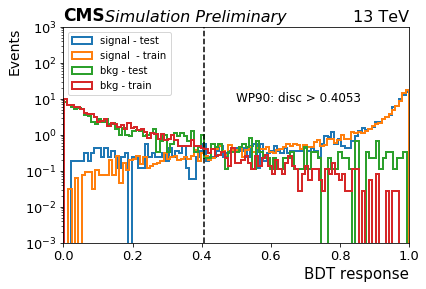

In [13]:
y_frame = pd.DataFrame({'truth':y_test, 'disc':y_pred})
y_frame_train = pd.DataFrame({'truth':y_train, 'disc':y_pred_train})

disc_bkg    = y_frame[y_frame['truth'] == 0]['disc'].values
disc_bkg_train    = y_frame_train[y_frame_train['truth'] == 0]['disc'].values
disc_signal = y_frame[y_frame['truth'] == 1]['disc'].values
disc_signal_train = y_frame_train[y_frame_train['truth'] == 1]['disc'].values
f = plt.figure()
ax = f.add_subplot(111)
plt.subplots_adjust(top=0.9, bottom=0.15, left=0.15, right=0.95)
plt.hist(disc_signal, density=True, bins=100, alpha=1.0, histtype='step', lw=2, label='signal - test')
plt.hist(disc_signal_train, density=True, bins=100, alpha=1.0, histtype='step', lw=2, label='signal  - train')
plt.hist(disc_bkg, density=True, bins=100, alpha=1.0, histtype='step', lw=2, label='bkg - test')
plt.hist(disc_bkg_train, density=True, bins=100, alpha=1.0, histtype='step', lw=2, label='bkg - train')

print(np.min(disc_signal_train))
plt.yscale('log')
plt.xlim([0.0, 1.0])
plt.ylim([0.001, 1000.0])
plt.legend(loc='upper left')
plt.xlabel('BDT response',horizontalalignment='right', x=1.0, fontsize=15)
plt.ylabel('Events',horizontalalignment='right', y=1.0, fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.axvline(x=WP90_threshold, color='black', linestyle='--')
# plt.axvline(x=WP99_threshold, color='black')
plt.text(0.5,0.7,'WP90: disc > %.4f'%WP90_threshold, fontsize=12, horizontalalignment='left', verticalalignment='top', transform=plt.gca().transAxes)
# plt.text(0.5,0.6,‘WP80: disc > %.4f’%WP80_threshold, fontsize=12, horizontalalignment=‘center’, verticalalignment=‘center’, transform=plt.gca().transAxes)
plt.text(0.0, 1.01, 'CMS', ha='left', va='bottom', transform=ax.transAxes, weight='bold', fontsize=17)
plt.text(0.12, 1.01, 'Simulation Preliminary', ha='left', va='bottom', transform=ax.transAxes, style='italic', fontsize=16)
plt.text(1.0, 1.01, '13 TeV', ha='right', va='bottom', transform=ax.transAxes, fontsize=16)
# plt.savefig("../../plots/MuonSystem_Analysis/"+bdt_name+'/discrimination.png', dpi=300)



AttributeError: 'numpy.ndarray' object has no attribute 'values'

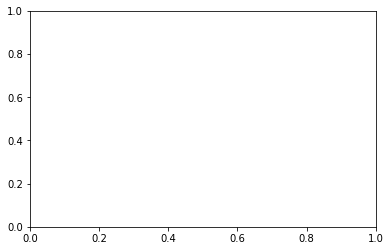

In [15]:
import pickle
# bdt_name = 'bdt_flatten_metfilter_me1112nohits_eta2p1_testsize0p2_abs_XYspread_v5'
# model = pickle.load(open( bdt_name+'.pickle', "rb" ))


#plot roc curve
f = plt.figure()
ax = f.add_subplot(111)
plt.subplots_adjust(top=0.9, bottom=0.15, left=0.15, right=0.95)

lw = 2
colors = ['r', 'g', 'b', 'c']
linestyle = ['solid', 'dotted', 'dashed']
# for i, ct in enumerate([10000]):
for i, ct in enumerate(ctau):


    for j, m in enumerate(mass):
        x = np.concatenate([df_bkg.values,df_signal[m][ct].values])
        x = np.hstack((x[:, :5], np.abs(x[:, 5:]))) ## change the last two variables to positive
        y = np.concatenate([np.zeros(len(df_bkg)),np.ones(len(df_signal[m][ct]))])
        y_pred = model.predict_proba(x)[:, 1]

        fpr, tpr, thr = roc_curve(y, y_pred)
        plt.plot(fpr, tpr, color=colors[i],linestyle = linestyle[j], lw=2, label='ggH, $m_{x} =$ '+str(m)+' GeV, c$\\tau$ = ' +str(int(ct))+' mm')
#         print('{0} \t {1} \t {2}'.format(ct, m, tpr[np.argmin(np.abs(fpr-0.01))]))
        print('{0}'.format( tpr[np.argmin(np.abs(fpr-0.01))]))

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([10E-4, 1.0])
plt.ylim([0.0, 1.05])
plt.ylabel('Signal Efficiency',horizontalalignment='right', y=1.0, fontsize=15)
plt.xlabel('Background Efficiency',horizontalalignment='right', x=1.0, fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xscale('log')
plt.axhline(y=0.9, color="black", linestyle='--')
plt.axhline(y=0.8, color="black")
# plt.text(0.05,0.1,'WP99: bkg eff = %.4f'%WP99_effBkg, fontsize=12)
# plt.text(0.05,0.2,'WP90: bkg eff = %.4f'%WP90_effBkg, fontsize=12)
# #plt.text(0.5,0.3,'WP90: S/sqrt(B) = %.2f'%WP90_significance, fontsize=12)
# plt.text(0.05,0.3,'AUC = %.4f'%AUC, fontsize=12)
# plt.title('Receiver operating characteristic example')
plt.legend(loc="center right", bbox_to_anchor=(1.2, 0.25, 0.5, 0.5))
plt.text(0.0, 1.02, 'CMS', ha='left', va='bottom', transform=ax.transAxes, weight='bold', fontsize=17)
plt.text(0.13, 1.02, 'Simulation Preliminary', ha='left', va='bottom', transform=ax.transAxes, style='italic', fontsize=16)
plt.text(0.99, 1.02, '13 TeV', ha='right', va='bottom', transform=ax.transAxes, fontsize=16)

plt.savefig("../../plots/MuonSystem_Analysis/"+bdt_name+"/ROC_curve_allSig.png", dpi=300,bbox_inches='tight')

plt.show()




In [52]:
94./2916

0.03223593964334705

# bdt efficiency

In [14]:
import scipy
import os

# print(np.array(y_pred[y_test == 0]))
# print(np.array(cscRechitClusterSize[indices_test][y_test == 0]).flatten())
# print(scipy.stats.pearsonr(bdt_score[k], cscClusterSize[k]))
# print(scipy.stats.pearsonr(bdt_score[k], jetMet_dPhiMin30[k]))

# wp90 =  0.9598022
# wp90 =  0.7802247
wp90 = WP90_threshold
# bdt_name = 'bdt_flatten_metfilter_me1112nohits_eta2p1_testsize0p2_abs_EtaPhi_v5'
outDir = '/storage/user/christiw/login-1/christiw/LLP/CMSSW_10_2_13/src/HiggsAnalysis/MuonSystemLimit/data/bdt_eff/'
if not os.path.isdir(outDir): print("OUTPUT DIR DOESN'T EXIST")
text_file = open(outDir+bdt_name+".txt", "w")
# text_file.write('#n_rechit, eff_total, eff_low, sigma, eff_high, sigma \n')

y_frame = pd.DataFrame({'truth':y_test, 'disc':y_pred})
y_frame_train = pd.DataFrame({'truth':y_train, 'disc':y_pred_train})

disc_bkg    = y_frame[y_frame['truth'] == 0]['disc'].values

print(len(indices_test), len(df_bkg_ncsc))
ncsc = nRechits[indices_test][y_test==0]
print(len(ncsc), len(disc_bkg))
print(np.count_nonzero(disc_bkg>wp90)/len(disc_bkg))
for n_rechit in np.arange(50,300,10):
    cond1 = ncsc > n_rechit
    cond1 = cond1[:,0]
    cond2 =  disc_bkg > wp90
    cond_gt = np.logical_and(cond1, cond2)
    cond_lt = np.logical_and(np.logical_not(cond1), cond2)
#     print(cond1.shape, cond2.shape)
#     print(np.count_nonzero(cond1), np.count_nonzero(cond2), np.count_nonzero(cond_gt), np.count_nonzero(cond_lt))
    eff_low = np.count_nonzero(cond_lt)/np.count_nonzero(np.logical_not(cond1))
    eff_high = np.count_nonzero(cond_gt)/np.count_nonzero(cond1)
    eff_total = np.count_nonzero(cond2)/len(cond2)
    sig_eff_low = (eff_low*(1-eff_low)/np.count_nonzero(np.logical_not(cond1)))**0.5
    sig_eff_high = (eff_high*(1-eff_high)/np.count_nonzero(cond1))**0.5
    assert(np.count_nonzero(cond_lt)+np.count_nonzero(cond_gt) == np.count_nonzero(cond2))
    print(n_rechit, eff_total,eff_low ,sig_eff_low , eff_high, sig_eff_high)
    text_file.write('{0}, {1}, {2}, {3}, {4} \n'.format(n_rechit, eff_low ,sig_eff_low , eff_high, sig_eff_high))

    

# for dphi in [0.0, 0.6, 1, 1.5, 2, 2.5]:
#     cond1 = jetMet_dPhiMin30[k] >= dphi
#     cond2 = bdt_score[k] > wp90
#     cond_gt = np.logical_and(cond1, cond2)
#     cond_lt = np.logical_and(np.logical_not(cond1), cond2)
#     print(dphi, np.count_nonzero(cond_gt)/np.count_nonzero(cond1))

    
text_file.close()

    

235961 3010
601 601
0.18136439267886856
50 0.18136439267886856 0.3142857142857143 0.07846932140863945 0.17314487632508835 0.01590418129163984
60 0.18136439267886856 0.18556701030927836 0.022789330640569604 0.1774193548387097 0.021697459890527522
70 0.18136439267886856 0.17590361445783131 0.018689700332065635 0.1935483870967742 0.028968597101092727
80 0.18136439267886856 0.18181818181818182 0.017531573087269773 0.1794871794871795 0.03547859977181339
90 0.18136439267886856 0.1786407766990291 0.016879254205180407 0.19767441860465115 0.042943884806284104
100 0.18136439267886856 0.18552875695732837 0.016743610488968688 0.14516129032258066 0.04473749421841784
110 0.18136439267886856 0.18363636363636363 0.01650972438439495 0.1568627450980392 0.050924169749476195
120 0.18136439267886856 0.18425760286225404 0.016397714545239937 0.14285714285714285 0.05399492471560389
130 0.18136439267886856 0.18309859154929578 0.016227557488596493 0.15151515151515152 0.062415594005386335
140 0.18136439267886856

[0.0, 1.0, 2.0, 3.0]
[1.0, 1.5, 2.0]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:44: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


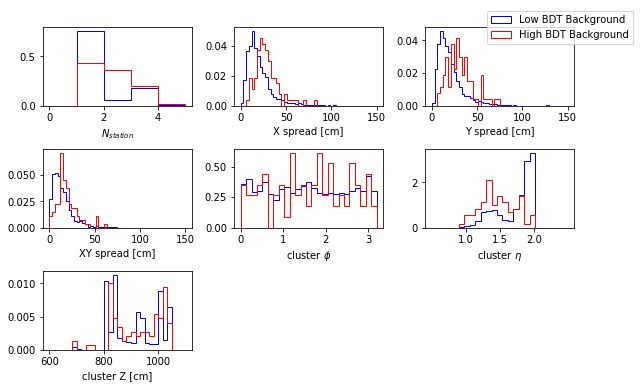

In [104]:
sig_flag = 0
lab = ['Background', 'Signal']
x_sig = x[y==sig_flag]
y_pred_sig = model.predict_proba(x_sig)[:, 1]


def trim_axs(axs, N):
    """little helper to massage the axs list to have correct length..."""
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]
columns = 3
fig1, axs = plt.subplots(int(len(variables)/columns)+1, columns, figsize=(8,5), constrained_layout=True)
# fig1, axs = plt.subplots(int(len(variables)/columns)+1, columns, figsize=(6,8), constrained_layout=True)


# for ax, case in zip(axs, cases):
#     ax.set_title('markevery=%s' % str(case))
trim_axs(axs, len(variables))

r = 0
c = 0
for i, var in enumerate(variables):
    bkg = axs[r,c].hist(x_sig[:,i][y_pred_sig< WP90_threshold], variables[i][3], (variables[i][4], variables[i][5]), density = True, histtype = 'step', label = 'Background', color = 'b')
    sig = axs[r,c].hist(x_sig[:,i][y_pred_sig>=WP90_threshold], variables[i][3], (variables[i][4], variables[i][5]), density = True, histtype = 'step', label = 'Signal', color = 'r')
    axs[r,c].set_xlabel(variables[i][2])
    if i == 5:
        print(list(axs[r,c].get_xticks()))
#         axs[r,c].set_xticks(list(axs[r,c].get_xticks()) + [1.5])
        axs[r,c].set_xticks([1.0, 1.5, 2.0])
        print(list(axs[r,c].get_xticks()))

    if c == columns-1:
        c = 0
        r+=1
        
    else:c+=1
#     if i == len(variables)-1:
fig1.legend([bkg, sig],     # The line objects
           labels=['Low BDT '+lab[sig_flag], 'High BDT '+lab[sig_flag]],   # The labels for each line
           loc="upper right",   # Position of legend
           borderaxespad=0.1,    # Small spacing around legend box
           bbox_to_anchor=(0.6, 0.55, 0.5, 0.5)
           )
#     h['OOT_data'] = create_TH1D(x[:,i][y==0], axis_title = [variables[i][2],'Events'], binning=[variables[i][3], variables[i][4], variables[i][5]])
#     h['MC_signal'] = create_TH1D(x[:,i][y==1], axis_title = [variables[i][2],'Events'], binning=[variables[i][3], variables[i][4], variables[i][5]])
# axs.tight_layout()


fig1.savefig("../../plots/MuonSystem_Analysis/"+bdt_name+'/high_low_bdt_'+lab[sig_flag]+'.png', dpi=300,bbox_inches='tight')




# plot feature importances

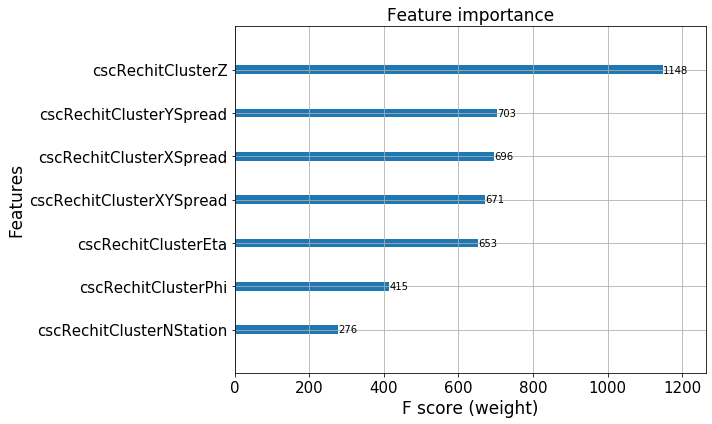

In [37]:
#plot feature importances

model.get_booster().feature_names = [row[1] for row in variables]

ax = xgb.plot_importance(model, max_num_features=len(variables), xlabel="F score (weight)")
fig = ax.figure
fig.set_size_inches(10, 6)
# plt.subplots_adjust(top=0.9, bottom=0.15, left=0.15, right=0.95)
# plt.xlabel('BDT response',horizontalalignment='right', x=1.0, fontsize=15)
# plt.ylabel('Events',horizontalalignment='right', y=1.0, fontsize=14)
ax.title.set_size(17)

ax.yaxis.label.set_size(17)
ax.xaxis.label.set_size(17)
plt.tick_params(axis='both', which='major', labelsize=15)


# plt.draw()
# os.makedirs("../../plots/MuonSystem_Analysis/"+bdt_name)
# plt.savefig("../../plots/MuonSystem_Analysis/"+bdt_name+'/feature_importance.png', dpi=300)
# 
ax.figure.tight_layout()
ax.figure.savefig("../../plots/MuonSystem_Analysis/"+bdt_name+'/feature_importance.png', dpi=300)

# compare two ROC curves

In [ ]:

import pickle
model = pickle.load(open( 'bdt_flatten_metfilter_me1112nohits_eta2p1_testsize0p2_abs_XYspread_v5.pickle', "rb" ))
model2 = pickle.load(open( 'bdt_flatten_metfilter_me1112nohits_eta2p1_testsize0p2_abs_XYspread_v7.pickle', "rb" ))


# y_pred = model.predict_proba(x_test)[:, 1]
# x_test2 = np.hstack((x_test[:, :3], x_test[:, 4:]))
# y_pred2 = model2.predict_proba(x_test2)[:, 1]

y_pred = model.predict_proba(x_test)[:, 1]
y_pred2 = model2.predict_proba(x_test)[:, 1]


fpr, tpr, thr = roc_curve(y_test, y_pred)
fpr2, tpr2, thr2 = roc_curve(y_test, y_pred2)

#plot roc curve
f = plt.figure()
ax = f.add_subplot(111)
plt.subplots_adjust(top=0.9, bottom=0.15, left=0.15, right=0.95)
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='w/o correction')
plt.plot(fpr2, tpr2, color='blue',
         lw=lw, label='with correction')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([10E-4, 1.0])
plt.ylim([0.0, 1.05])
plt.ylabel('Signal Efficiency',horizontalalignment='right', y=1.0, fontsize=15)
plt.xlabel('Background Efficiency',horizontalalignment='right', x=1.0, fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xscale('log')
plt.axhline(y=0.9, color="black", linestyle='--')
plt.axhline(y=0.8, color="black")
# plt.text(0.05,0.1,'WP99: bkg eff = %.4f'%WP99_effBkg, fontsize=12)
# plt.text(0.05,0.2,'WP90: bkg eff = %.4f'%WP90_effBkg, fontsize=12)
#plt.text(0.5,0.3,'WP90: S/sqrt(B) = %.2f'%WP90_significance, fontsize=12)
# plt.text(0.05,0.3,'AUC = %.4f'%AUC, fontsize=12)
# plt.title('Receiver operating characteristic example')
plt.legend(loc="center right")
plt.show()

# correlation with csc rechit size

In [ ]:
f_heat, ax = plt.subplots(figsize=(8, 8))
# ax = sns.kdeplot(np.array(ncsc_signal)[:,0], np.array(disc_signal_old), cmap="Reds", shade=True, shade_lowest=False)
print(cscRechitClusterSize[indices_test].shape)
print(y_pred.shape)
ax = sns.kdeplot(np.array(y_pred), np.array(cscRechitClusterSize[indices_test]),
                 cmap="Blues", shade=True, shade_lowest=False)
# ax = sns.kdeplot(np.array(ncsc_bkg)[:,0], np.array(disc_bkg_normal),
#                  cmap="Reds", shade=False, shade_lowest=False)
# ax = plt.scatter(np.array(ncsc_signal)[:,0], np.array(disc_signal_old), alpha=0.5)
# ax = sns.kdeplot(np.array(ncsc_signal)[:,0], disc_signal_in,
#                  cmap="Greens", shade=True, shade_lowest=False)
plt.ylim(-5, 200)
plt.xlabel('BDT Discriminator')
plt.ylabel('$N_{CSC}$')
plt.title('Veto Training: Correlation Plot')

# Add labels to the plot0.0011161413
red = sns.color_palette("Reds")[-2]
blue = sns.color_palette("Blues")[-2]
# green = sns.color_palette("Greens")[-2]
# ax.text(2.5, 8.2, "No Vetoes", size=16, color=blue)
# ax.text(3.8, 4.5, "Trained on Vetoes", size=16, color=red)
# ax.text(2.0, 7, "Trained on Vetoes: In-time", size=16, color=green)

13


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).


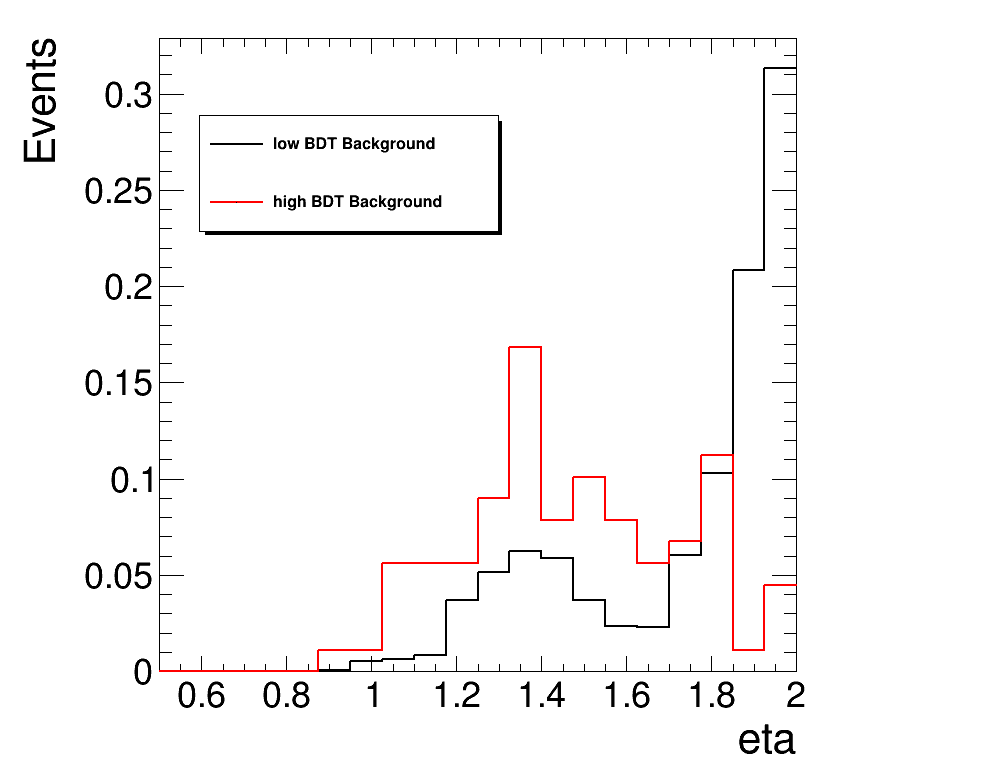

In [14]:
# Plotting ncsc
start_t = time.time()
c = rt.TCanvas('c','c', 1000, 800)
h = {}
# leg = rt.TLegend(0.50,0.75,0.97,0.93)
leg = rt.TLegend(0.2,0.70,0.5,0.85)
leg.SetTextSize(0.022)
# leg.SetTextFont(42)
leg.SetEntrySeparation(0.01)


sig_flag = 0
lab = ['Background', 'Signal']
x_sig = x[y==sig_flag]
y_pred_sig = model.predict_proba(x_sig)[:, 1]

# h[k] = create_TH2D(np.column_stack((np.array(y_pred[y_test == 0]), np.array(cscRechitClusterSize[indices_test][y_test == 0]))),\
#                    axis_title = ['BDT score','N_{rechits}','Events'], binning=[50,0,1,50,0,600])

# h[k] = h[k].ProfileX()
h['bkg'] = create_TH1D(x_sig[:,5][y_pred_sig< WP90_threshold], axis_title = ['eta', 'Events'], binning = [20,0.5,2])
h['sig'] = create_TH1D(x_sig[:,5][y_pred_sig>= WP90_threshold], axis_title = ['eta', 'Events'], binning = [20,0.5,2])
print(np.count_nonzero(x_sig[:,5]<1))

h['bkg'].SetLineColor(std_color_list[0])
h['sig'].SetLineColor(std_color_list[1])
leg.AddEntry(h['bkg'], 'low BDT '+lab[sig_flag])
leg.AddEntry(h['sig'], 'high BDT '+lab[sig_flag])

#     h[k].SetMaximum(10E5)
#     h[k].SetMinimum(1)
h['bkg'].DrawNormalized()
h['sig'].DrawNormalized('same')
c.SetRightMargin(0.2)

leg.Draw()
# if setlog: 
c.SetLogz()
c.Draw()




In [ ]:
np.arange(50,300,10)

In [ ]:
import scipy
# print(np.array(y_pred[y_test == 0]))
# print(np.array(cscRechitClusterSize[indices_test][y_test == 0]).flatten())
print(scipy.stats.pearsonr(np.array(y_pred[y_test == 0]), np.array(cscRechitClusterSize[indices_test][y_test == 0]).flatten()))

# wp90 =  0.9598022
wp90 =  0.7802
# WP90_effBkg: 0.06531049250535331
for n_rechit in np.arange(50,300,10):
    cond1 = cscRechitClusterSize[indices_test][y_test == 0]> n_rechit
    cond2 = y_pred[y_test == 0] > wp90
    cond = np.logical_and(cond1[:,0], cond2)
#     print(np.count_nonzero(cond1))
#     print("n_rechits", str(n_rechit), np.count_nonzero(cond)/np.count_nonzero(cond1))
#     print( str(n_rechit), np.count_nonzero(cond1), np.count_nonzero(cond)/np.count_nonzero(cond1))
    print( str(n_rechit), np.count_nonzero(cond)/np.count_nonzero(cond1))

    cond1 = cscRechitClusterSize[indices_test][y_test == 0] < n_rechit
    cond2 = y_pred[y_test == 0] > wp90
    cond = np.logical_and(cond1[:,0], cond2)
    print("n_rechits", str(n_rechit), np.count_nonzero(cond)/np.count_nonzero(cond1[:,0]))


# Correlation with delta phi

In [ ]:
import math
def deltaPhi( phi1,  phi2):
    dphi = phi1-phi2
    while (dphi > math.pi):
        dphi -= 2*math.pi
    while (dphi <= -math.pi):
        dphi += 2*math.pi
    return dphi
def deltaR(eta1, phi1, eta2, phi2):
    dphi = deltaPhi(phi1,phi2)
    deta = eta1 - eta2
    return (dphi*dphi + deta*deta)**0.5

In [ ]:
%%time

gLLP_beta = {}
jetPt = {}
jetPhi = {}
metPhi = {}

jetMet_dPhi = {}
jetMet_dPhiMin = {}
jetMet_dPhiMin4 = {}
jetMet_dPhiMin4_50 = {}

cscClusterSize = {}
cscRechitClusterXSpread = {}
cscRechitClusterYSpread = {}
cscRechitClusterNStation = {}
cscRechitClusterEtaPhiSpread = {}
cscRechitClusterPhiSpread = {}
cscRechitClusterEtaSpread = {}
cscRechitClusterX = {}
cscRechitClusterY = {}
cscRechitClusterZ = {}
cscRechitClusterPhi = {}
cscClusterJetVetoPt = {}
cscRechitClusterEta = {}

cscRechitClusterMaxStationRatio = {}
cscRechitClusterNStation = {}
cscRechitClusterNChamber = {}
cscRechitClusterMet_dPhi = {}
jetMet_dPhiMin30 = {}
dphiMet_cluster = {}
bdt_score = {}
# make predictions for test data

import pickle
model = pickle.load(open( 'bdt_flatten_metfilter_me1112nohits_eta2p1_testsize0p2_abs_EtaPhi_v2.pickle', "rb" ))
y_pred = model.predict_proba([1,2,3,4,4,5,6])[:, 1]

k = 'data'

T = tree_bkg['data']
 
##### bdt variables ####
sel_ev = T.array('nCscRechitClusters') > 0
cscRechitClusterPhi[k] = T.array('cscRechitClusterPhi')[sel_ev][:,0].flatten()
cscRechitClusterXSpread[k] = T.array('cscRechitClusterXSpread')[sel_ev][:,0].flatten()
cscRechitClusterYSpread[k] = T.array('cscRechitClusterYSpread')[sel_ev][:,0].flatten()
cscRechitClusterEtaSpread[k] = T.array('cscRechitClusterEtaSpread')[sel_ev][:,0].flatten()
cscRechitClusterPhiSpread[k] = T.array('cscRechitClusterPhiSpread')[sel_ev][:,0].flatten()
cscRechitClusterNStation[k] = T.array('cscRechitClusterNStation')[sel_ev][:,0].flatten()
cscRechitClusterEtaPhiSpread[k] = T.array('cscRechitClusterEtaPhiSpread')[sel_ev][:,0].flatten()
cscRechitClusterX[k] = T.array('cscRechitClusterX')[sel_ev][:,0].flatten()
cscRechitClusterY[k] = T.array('cscRechitClusterY')[sel_ev][:,0].flatten()
cscRechitClusterZ[k] = T.array('cscRechitClusterZ')[sel_ev][:,0].flatten()
cscRechitClusterEta[k] = T.array('cscRechitClusterEta')[sel_ev][:,0].flatten()
cscRechitClusterPhi[k] = T.array('cscRechitClusterPhi')[sel_ev][:,0].flatten()

# if bdt_name == 'bdt_flatten_metfilter_me1112nohits_eta2p1_testsize0p2_abs':

#     bdt_var = {'cscRechitClusterXSpread': cscRechitClusterXSpread[k],
#      'cscRechitClusterYSpread': cscRechitClusterYSpread[k],
#      'cscRechitClusterNStation':cscRechitClusterNStation[k],
#      'cscRechitClusterEtaPhiSpread':cscRechitClusterEtaPhiSpread[k],
#      'cscRechitClusterX':cscRechitClusterX[k],
#      'cscRechitClusterY':cscRechitClusterY[k],
#      'cscRechitClusterZ':cscRechitClusterZ[k],
#     }
# elif bdt_name == 'bdt_flatten_metfilter_me1112nohits_eta2p1_testsize0p2_abs_EtaPhi':
   
# else:
#     print('BDT NAME NOT FOUND')
bdt_var = {'cscRechitClusterNStation': cscRechitClusterNStation[k],
'cscRechitClusterEtaSpread': cscRechitClusterEtaSpread[k],
'cscRechitClusterPhiSpread':cscRechitClusterPhiSpread[k],
'cscRechitClusterEtaPhiSpread':cscRechitClusterEtaPhiSpread[k],
'cscRechitClusterPhi':cscRechitClusterPhi[k],
'cscRechitClusterEta':np.abs(cscRechitClusterEta[k]),
'cscRechitClusterZ':np.abs(cscRechitClusterZ[k]),
}

dataset = pd.DataFrame(bdt_var)
bdt_score[k] = model.predict_proba(dataset.values)[:, 1]

# dphiMet_cluster[k] = np.abs(T.array('cscRechitClusterMet_dPhi'))[sel_ev][:,0].flatten()[bdt_sel]
metPhi[k] = T.array('metPhi')[sel_ev]
jetPhi[k] = T.array('jetPhi')[sel_ev]
jetPt[k] = T.array('jetPt')[sel_ev]
# jetMet_dPhiMin30[k] = []
# for ev in range(len(jetPhi[k])):
#     dphi_min_temp = 999
#     for i in range(len(jetPhi[k][ev])):
#         if jetPt[k][ev][i] < 30: continue
#         dphi_temp = abs(deltaPhi(metPhi[k][ev],jetPhi[k][ev][i]))
#         if dphi_min_temp > dphi_temp: dphi_min_temp = dphi_temp
#     jetMet_dPhiMin30[k].append(dphi_min_temp)
# jetMet_dPhiMin30[k] = np.array(jetMet_dPhiMin30[k])


cscClusterSize[k] =  T.array('cscRechitClusterSize')[sel_ev][:,0].flatten()
print(len(cscClusterSize[k]), len(bdt_score[k]))

In [ ]:
# Plotting ncsc
start_t = time.time()
c = rt.TCanvas('c','c', 1000, 800)
h = {}
# leg = rt.TLegend(0.50,0.75,0.97,0.93)
leg = rt.TLegend(0.58,0.70,0.94,0.85)
leg.SetTextSize(0.022)
# leg.SetTextFont(42)
leg.SetEntrySeparation(0.01)
print(bdt_score[k])
# print(cscClusterSize[k].flatten())
# h[k] = create_TH2D(np.column_stack((bdt_score[k], cscClusterSize[k])), axis_title = ['BDT score','N_{rechits}','Events'], binning=[50,0,1,50,0,600])
h[k] = create_TH2D(np.column_stack((bdt_score[k], jetMet_dPhiMin30[k])), axis_title = ['BDT score','#Delta#phi(jet, met)','Events'], binning=[50,0,1,50,0,3.2])

# h[k] = h[k].ProfileX()
h[k].GetXaxis().SetLabelSize(0.04)

h[k].SetLineColor(std_color_list[0])
h[k].Draw('colz')
c.SetRightMargin(0.2)


# if setlog: 
c.SetLogz()
c.Draw()
print(time.time()-start_t)


In [ ]:
import scipy
# print(np.array(y_pred[y_test == 0]))
# print(np.array(cscRechitClusterSize[indices_test][y_test == 0]).flatten())
k = 'data'
print(scipy.stats.pearsonr(bdt_score[k], cscClusterSize[k]))
# print(scipy.stats.pearsonr(bdt_score[k], jetMet_dPhiMin30[k]))

# wp90 =  0.9598022
wp90 =  0.7802247
outDir = '/storage/user/christiw/login-1/christiw/LLP/CMSSW_10_2_13/src/HiggsAnalysis/MuonSystemLimit/data/bdt_eff/'
fileName = 'bdt_flatten_metfilter_me1112nohits_eta2p1_testsize0p2_abs_EtaPhi_v2'
text_file = open(outDir+fileName+".txt", "w")
print(np.count_nonzero(bdt_score[k]>wp90)/len(bdt_score[k]))
for n_rechit in np.arange(50,300,10):
    cond1 = cscClusterSize[k]> n_rechit
    cond2 =  bdt_score[k] > wp90
    cond_gt = np.logical_and(cond1, cond2)
    cond_lt = np.logical_and(np.logical_not(cond1), cond2)
    print(n_rechit, np.count_nonzero(cond_lt)/np.count_nonzero(np.logical_not(cond1)), np.count_nonzero(cond_gt)/np.count_nonzero(cond1))
    
    text_file.write('{0}, {1}, {2} \n'.format(n_rechit,  np.count_nonzero(cond_lt)/np.count_nonzero(np.logical_not(cond1)), np.count_nonzero(cond_gt)/np.count_nonzero(cond1)))

    

# for dphi in [0.0, 0.6, 1, 1.5, 2, 2.5]:
#     cond1 = jetMet_dPhiMin30[k] >= dphi
#     cond2 = bdt_score[k] > wp90
#     cond_gt = np.logical_and(cond1, cond2)
#     cond_lt = np.logical_and(np.logical_not(cond1), cond2)
# #     print(np.count_nonzero(cond1))
# #     print("n_rechits", str(n_rechit), np.count_nonzero(cond)/np.count_nonzero(cond1))
# #     print( str(n_rechit), np.count_nonzero(cond1), np.count_nonzero(cond)/np.count_nonzero(cond1))
# #     print( str(dphi), np.count_nonzero(cond)/np.count_nonzero(cond1))
# #     print(len(cond1), np.count_nonzero(np.logical_not(cond1)), np.count_nonzero(cond1))
# #     print(dphi, np.count_nonzero(cond_lt)/np.count_nonzero(np.logical_not(cond1)), np.count_nonzero(cond_gt)/np.count_nonzero(cond1))
#     print(dphi, np.count_nonzero(cond_gt)/np.count_nonzero(cond1))

# #     cond1 = jetMet_dPhiMin30[k] < dphi
# #     cond2 = bdt_score[k] > wp90
# #     cond = np.logical_and(cond1[:,0], cond2)
# #     print("n_rechits", str(n_rechit), np.count_nonzero(cond)/np.count_nonzero(cond1[:,0]))

    
text_file.close()

    

# event yield vs. ncsc

# significance